In [1]:
import scanpy as sc
import scvi
from matplotlib import rcParams
import matplotlib.pyplot as plt
from liana.method import cellphonedb

folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat/"

In [2]:
adata = sc.read(folder_path + "adata_annotated.h5ad")

In [8]:
adata

AnnData object with n_obs × n_vars = 276625 × 34223
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', 'cnv_score', 'tumor_cell', 'cell_type'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'dendrogram_cell_type', 'leiden', 'leiden_colors', 'markers', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [6]:
filtered_adata = adata[adata.obs['cell_type'].isin(['Oligodendrocyte', 'Microglia']), :]

In [10]:
del adata

In [9]:
filtered_adata.write_h5ad(folder_path + "filtered_adata.h5ad")

In [11]:
cellphonedb(
    filtered_adata,
    groupby = "cell_type",
    use_raw = False,
    return_all_lrs = True,
    layer = 'scvi_normalized',
    verbose = True
)
# scvi_normalized layer를 sparse csr matrix로 바꾸는데 16분. 아마 램 문제도 이 과정에서 생기는 듯.
# 샘플 만드는데 21분. 그 이후 17분 더 걸림. 총 약 38분 소요.

Using the `scvi_normalized` layer!
Converting to sparse csr matrix!
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
c:\Users\heung\anaconda3\Lib\site-packages\liana\method\_pipe_utils\_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
['ABCF2_2', 'ALDOA_2', 'ARHGAP11B_2', 'ATXN7_2', 'BMS1P4_2', 'COG8_2', 'DIABLO_2', 'EMG1_2', 'HSPA14_2', 'IGF2_2', 'LINC00484_2', 'LINC01297_2', 'LINC01481_2', 'MATR3_2', 'POLR2J3_2', 'POLR2J4_2', 'RF00003_10', 'RF00003_11', 'RF00003_12', 'RF00003_3', 'RF00003_4', 'RF00003_5', 'RF00003_8', 'RF00003_9', 'RF00004_10', 'RF00012_44', 'RF00017_107', 'RF00017_124', 'RF00017_57', 'RF00017_87', 'RF00019_121', 'RF00019_164', 'RF00019_192', 'RF00019_206', 'RF00019_2

Generating ligand-receptor stats for 91920 samples and 1710 features


c:\Users\heung\anaconda3\Lib\site-packages\liana\resource\_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


c:\Users\heung\anaconda3\Lib\site-packages\liana\resource\_reassemble_complexes.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

In [24]:
filtered_adata

AnnData object with n_obs × n_vars = 91920 × 34223
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', 'cnv_score', 'tumor_cell', 'cell_type'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'dendrogram_cell_type', 'leiden', 'leiden_colors', 'markers', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap', 'liana_res'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

c:\Users\heung\anaconda3\Lib\site-packages\liana\plotting\_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


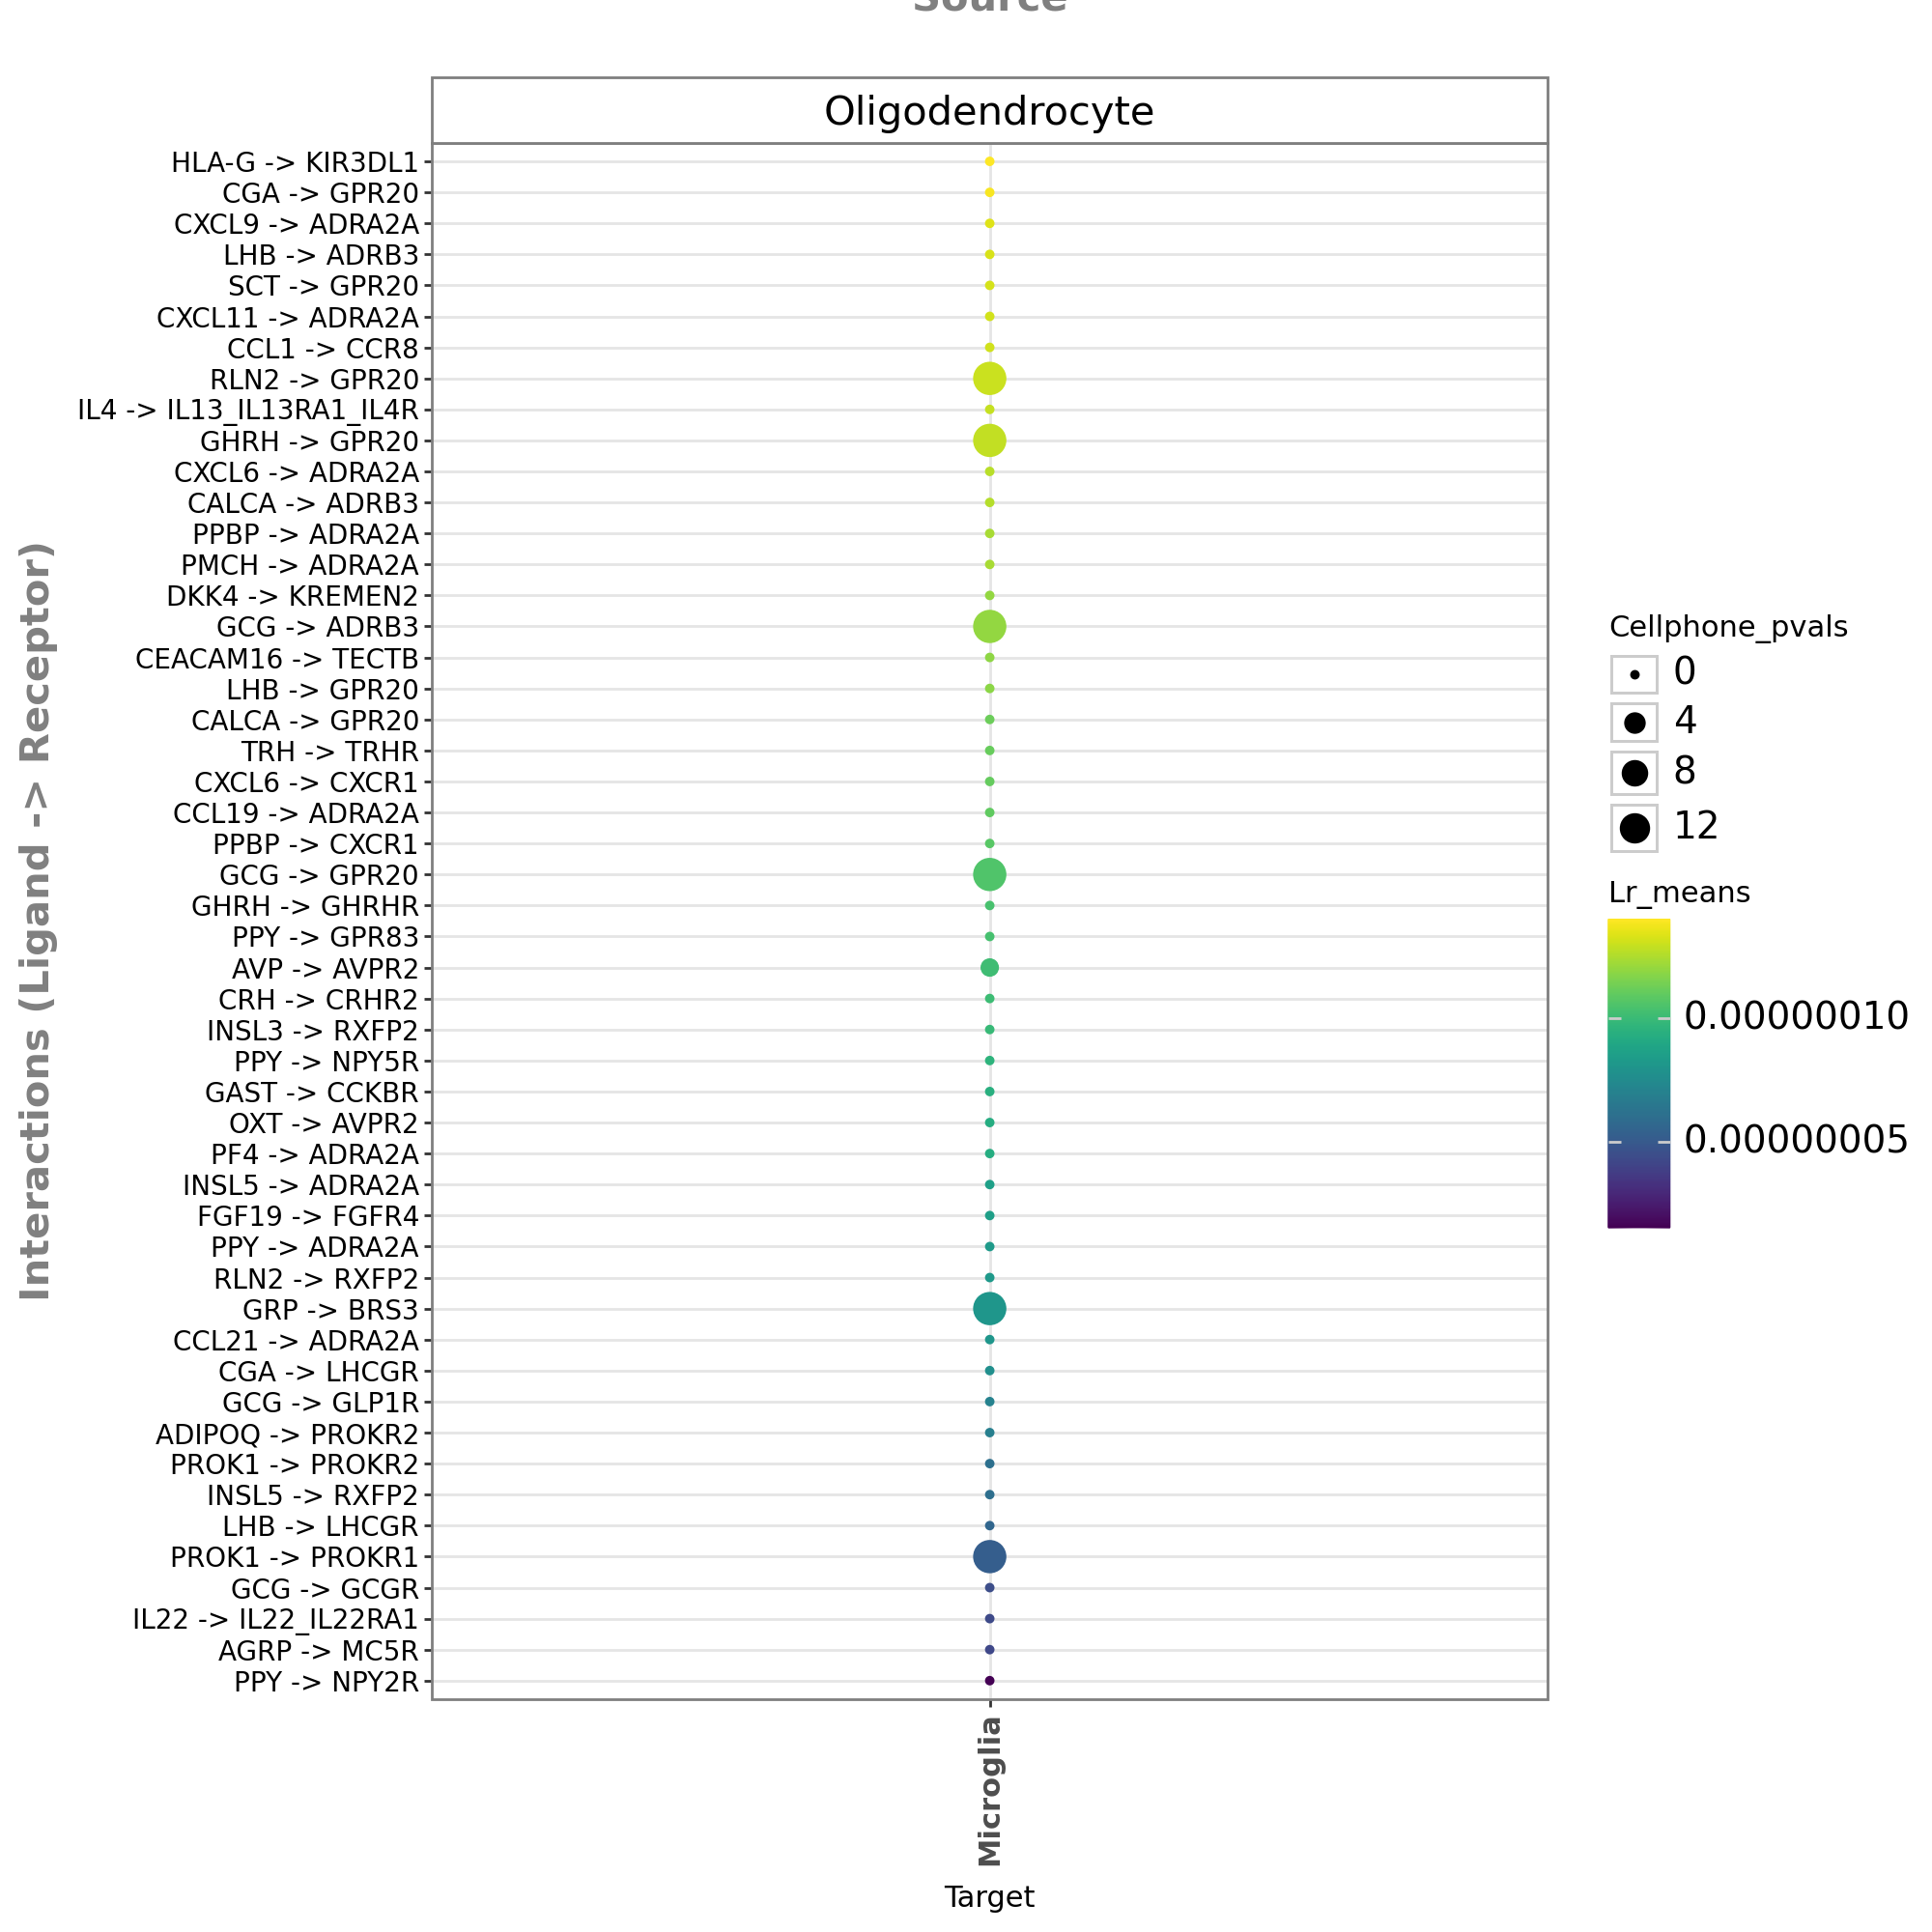

In [23]:
import liana as li
li.pl.dotplot(
    adata = filtered_adata,
    colour="lr_means",
    size="cellphone_pvals",
    inverse_size=True,  # we inverse sign since we want small p-values to have large sizes
    # We choose only the cell types which we wish to plot
    source_labels=['Oligodendrocyte'],

    target_labels=['Microglia'],

    # since cpdbv2 suggests using a filter to FPs
    # we can filter the interactions according to p-values <= 0.01
    # filterby = "cellphone_pvals",
    # filter_lambda=lambda x: x <= 0.01,
    # as this type of methods tends to result in large numbers
    # of predictions, we can also further order according to
    # expression magnitude
    orderby="lr_means",
    orderby_ascending=True,  # we want to prioritize those with highest expression
    top_n=50,  # and we want to keep only the top 20 interactions
    figure_size=(10, 10),
    size_range=(1, 6),
)